#### Import Necessary Packages
---

In [1]:
from myToolBox.utils import testModel, plotLoss, encodeLabel
from myToolBox.models import KNN, LogisticRegression, TL_FC_NN_Classifier
from sklearn.naive_bayes import GaussianNB
from myToolBox.functions import CrossEntropy, ReLU, Softmax
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import json
import numpy as np

#### Prepare Data
---

In [2]:
X = []
Y = []
feature_dict = {}
answer_dict = {}
files = ["./stock_data/tse_stage3.json", "./stock_data/otc_stage3.json"]
for i, file in enumerate(files):
    with open(file) as f:
        data = json.loads(f.read())
        stockType = data["type"]
        allStocks = data["stock"]
        for sid in allStocks:
            X.append(allStocks[sid])
            Y.append([stockType])
            feature_dict[sid] = allStocks[sid]
            answer_dict[sid] = stockType
X = np.array(X, dtype=np.float32)
Y, decode_map = encodeLabel(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

##### Some Helper Functions

In [3]:
def selectStock(*sids, scaler):
    res = []
    for sid in sids:
        res.append(feature_dict[sid])
    res = np.array(res, dtype=np.float32)
    res = scaler.transform(res)
    return res
def getAnswer(*sids):
    res = []
    for sid in sids:
        res.append(answer_dict[sid])
    return np.array(res)

##### Standardize the data
###### Can try and see how will it affect the performance if we emit this step

In [4]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#### Try Each Model
---

##### KNN

In [5]:
knnModel = KNN(k=3)
knnModel.fit(x_train, y_train)
testModel(knnModel, x_train, y_train, x_test, y_test)

Training Accuracy: 0.7645
Testing Accuracy: 0.6391


##### Gaussian Naive Base

In [6]:
gnb = GaussianNB()
gnb.fit(x_train, y_train.squeeze())
testModel(gnb, x_train, y_train, x_test, y_test)

Training Accuracy: 0.5443
Testing Accuracy: 0.5199


##### Logistic Regression

Training Accuracy: 0.7821
Testing Accuracy: 0.7156


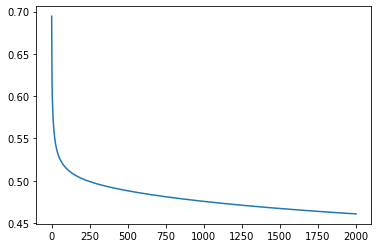

In [7]:
logRe = LogisticRegression()
logRe.fit(x_train, y_train, lr=1e-4, epoch=2000)
testModel(logRe, x_train, y_train, x_test, y_test)
plotLoss(logRe)

##### Two-Layer Fully-Connected Neural Network

Training Accuracy: 0.7232
Testing Accuracy: 0.7095


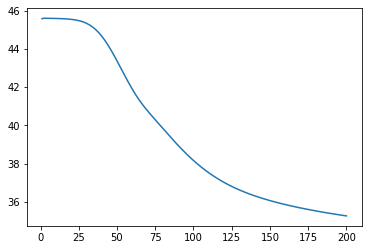

In [8]:
nn = TL_FC_NN_Classifier()
nn.define(x_train.shape[1], 280, 2)
nn.loss_function = CrossEntropy()
# nn.activation_function = ReLU()
nn.fit(x_train, y_train, lr=1e-4, batch_size=20, epoch=200)
nn.save("saved_weights")
testModel(nn, x_train, y_train, x_test, y_test)
plotLoss(nn)

In [14]:
nn2 = TL_FC_NN_Classifier()
nn2.define(x_train.shape[1], 280, 2)
nn2.loss_function = CrossEntropy()
nn2.load(np.load("saved_weights.npz"))
testModel(nn2, x_train, y_train, x_test, y_test)

Training Accuracy: 0.7232
Testing Accuracy: 0.7095


##### Decision Tree

In [10]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(x_train, y_train.squeeze())
testModel(dt, x_train, y_train, x_test, y_test)

Training Accuracy: 0.8211
Testing Accuracy: 0.7003


##### Random Forest

In [11]:
rf = RandomForestClassifier(max_depth=5, n_estimators=10)
rf.fit(x_train, y_train.squeeze())
testModel(rf, x_train, y_train, x_test, y_test)

Training Accuracy: 0.8119
Testing Accuracy: 0.7492


##### Support Vector Machine

In [12]:
svm = SVC(kernel='rbf')
svm.fit(x_train, y_train.squeeze())
testModel(svm, x_train, y_train, x_test, y_test)

Training Accuracy: 0.8050
Testing Accuracy: 0.7095


In [13]:
sidQueryList = ["2303", "3105", "3711", "6239", "3035", "3034", "6425", "2379"]
print(nn.predict(selectStock(*sidQueryList, scaler=scaler)))
print(getAnswer(*sidQueryList))

[1 1 1 1 1 1 0 1]
['tse' 'otc' 'tse' 'tse' 'tse' 'tse' 'otc' 'tse']
